In [1]:
import pickle
import numpy as np 

from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [2]:
x_train = np.load('x_train.npy')
x_cv = np.load('x_cv.npy')

y_train = np.load('y_train.npy')
y_cv = np.load('y_cv.npy')

x_train.shape, x_cv.shape, y_train.shape, y_cv.shape

((74708, 64, 64, 3), (18677, 64, 64, 3), (74708, 1), (18677, 1))

In [3]:
with open('x_test_fake_mask.pickle', 'rb') as f:
    x_test_fake_mask = pickle.load(f)
    
with open('x_test_fake.pickle', 'rb') as f:
    x_test_fake = pickle.load(f)
    
len(x_test_fake_mask), len(x_test_fake)

(10, 10)

In [4]:
from keras.models import load_model

model = load_model('best_model(1).h5')
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 131201    
Total params: 14,845,889
Trainable params: 2,491,009
Non-trainable params: 12,354,880
_________________________________________________________________


In [5]:
train_score = model.evaluate(x_train, y_train, verbose=0)

In [6]:
train_score

[0.10754902740311059, 0.9659875783016756]

In [7]:
cv_score = model.evaluate(x_cv, y_cv)
cv_score

18677/18677 [==============================] - 270s 14ms/step


[0.5778609834519266, 0.8104085238624412]

In [10]:
import matplotlib.pyplot as plt

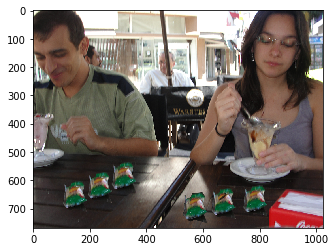

In [11]:
plt.imshow(x_test_fake[0])

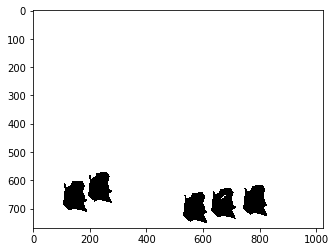

In [13]:
plt.imshow(x_test_fake_mask[0], cmap = 'gray')

In [16]:
def count_255(mask):
    i=0
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]==255:
                i+=1
    return i

In [22]:
# do the same for the scenery image
stride= 64

im = x_test_fake[0]
mask_im = x_test_fake_mask[0]

images = [] 
images_mask = [] 

y_truth = [] 

threshold = 1024

for i in range(0, im.shape[0], stride):
    for j in range(0, im.shape[1], stride):
        
        if len(np.array(im[i:i+stride, j: j+stride, :]).flatten()) != 64 * 64 * 3:
            continue
        
        
        # 0 = pristine ; 1 = fake 
        if sum(sum(mask_im[i:i+stride, j: j+stride] == 255)) == 64*64:
            y_truth.append(0)
        else:
            c_255=count_255(mask_im[i:i+stride, j: j+stride]) # 255 = white
            c_0 = 64 * 64 - c_255 # 0 = black 
            if c_0 > threshold:
                y_truth.append(1)
                images_mask.append(mask_im[i:i+stride, j: j+stride])
            else:
                y_truth.append(0)
            
        images.append(np.array(im[i:i+stride, j: j+stride, :]))


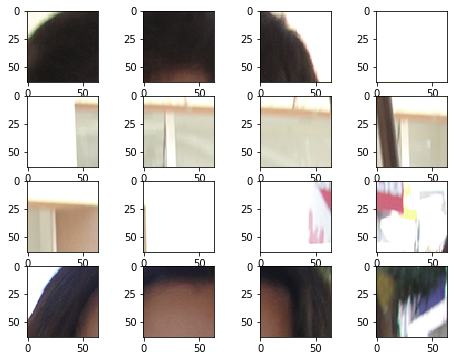

In [23]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(8, 6))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(images[i])


In [24]:
# finding the index of 1's 
idx = [i for i, e in enumerate(y_truth) if e == 1]
idx

[146, 147, 156, 161, 162, 163, 168, 169, 170, 171, 172, 184, 185, 186]

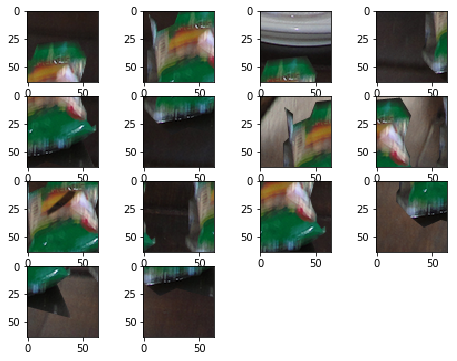

In [26]:
fig = plt.figure(figsize=(8, 6))
j = 0
for i in idx:
    ax = fig.add_subplot(4, 4, j+1)
    ax.imshow(images[i])
    j += 1

In [53]:
# y_pred = model.predict_classes(np.array(images))
y_pred = model.predict(np.array(images))

In [61]:
sum( (y_pred > 0.9) ==  np.array(y_truth).reshape(-1, 1))/len(y_truth)

array([0.71354167])

In [64]:
y_pred = y_pred > 0.9

In [65]:
im_vis = x_test_fake[0].copy()

stride= 64
count = 0 

for i in range(0, im_vis.shape[0], stride):
    for j in range(0, im_vis.shape[1], stride):
        
        try:

            if y_pred[count][0] == 1:
                im_vis[i:i+stride, j: j+stride, 0] = 255

            count += 1 
        except:
            pass




In [66]:
# y_pred = model.predict(np.array(images))

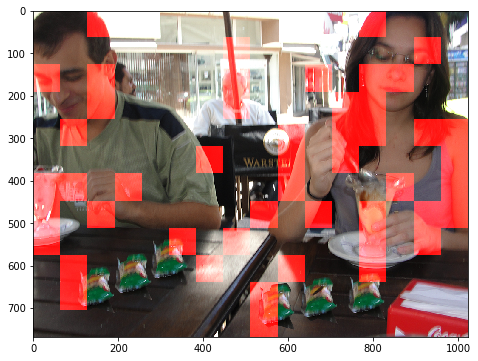

In [67]:
plt.figure(figsize=(8, 6))
plt.imshow(im_vis, cmap = 'gray')

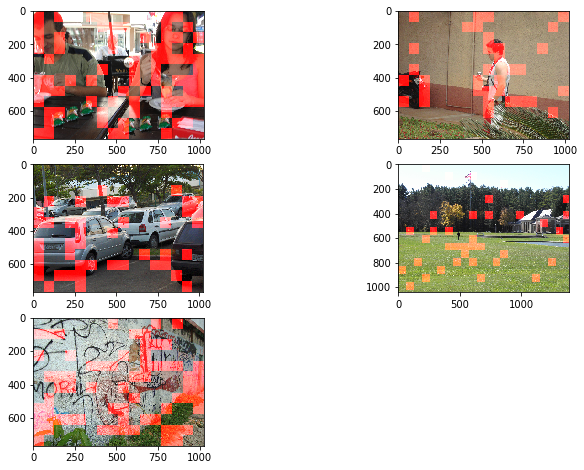

In [71]:
# do the same for the scenery image
stride= 64
fig = plt.figure(figsize=(12, 8))

for i in range(len(x_test_fake)//2):
    
    ref = i 

    im = x_test_fake[i]
    mask_im = x_test_fake_mask[i]

    images = [] 
    images_mask = [] 

    y_truth = [] 

    for i in range(0, im.shape[0], stride):
        for j in range(0, im.shape[1], stride):

            if len(np.array(im[i:i+stride, j: j+stride, :]).flatten()) != 64 * 64 * 3:
                continue


            # 0 = pristine ; 1 = fake 
            if sum(sum(mask_im[i:i+stride, j: j+stride] == 255)) == 64*64:
                y_truth.append(0)
            else:
                c_255=count_255(mask_im[i:i+stride, j: j+stride]) # 255 = white
                c_0 = 64 * 64 - c_255 # 0 = black 
                if c_0 > threshold:
                    y_truth.append(1)
                    images_mask.append(mask_im[i:i+stride, j: j+stride])
                else:
                    y_truth.append(0)

            images.append(np.array(im[i:i+stride, j: j+stride, :]))
            
    y_pred = model.predict_classes(np.array(images))
    
    im_vis = x_test_fake[ref].copy()
    count = 0 

    for i in range(0, im_vis.shape[0], stride):
        for j in range(0, im_vis.shape[1], stride):

            try:

                if y_pred[count][0] == 1:
                    im_vis[i:i+stride, j: j+stride, 0] = 255

                count += 1 
            except:
                pass
            
    ax = fig.add_subplot(3, 2, ref+1)
    ax.imshow(im_vis, cmap = 'gray')




In [72]:
import os 
from PIL import Image

folders =['DDA_test/pristine', 'DDA_test/fake']
valid_images= ['.jpg', '.jpeg', '.png']

forged =[]
pristine = [] 
mask = [] 
y = []

for folder in folders:
  path = folder + '/'
  
  for f in os.listdir(path):
    
    ext = os.path.splitext(f)[1]
    
    if ext.lower() not in valid_images:
      continue 
      
    img_path = path + f

    if 'mask' in img_path[-10:]: 
      continue 
      
    
    im = np.array(Image.open(img_path))
    
    # those are the images with plain patches (discarded)
    if len(im.shape) < 3:
      continue 
    
    if im.shape[-1] == 4:
        im = im[:, :, :3]

    
    if folder == 'DDA_test/fake':
      forged.append(im.reshape(im.shape[0], im.shape[1], im.shape[2]))
    
      name, ext = f.split('.')
      img_path = path + name + '.mask.' + ext
      
      im = np.array(Image.open(img_path).convert('L'))

      mask.append(im)
    else:
      pristine.append(im.reshape(im.shape[0], im.shape[1], im.shape[2]))
                        
    if folder == 'DDA_test/fake':
      y.append(1)
    elif folder == 'DDA_test/pristine':
      y.append(0)
      

y = np.array(y).reshape(-1, 1)

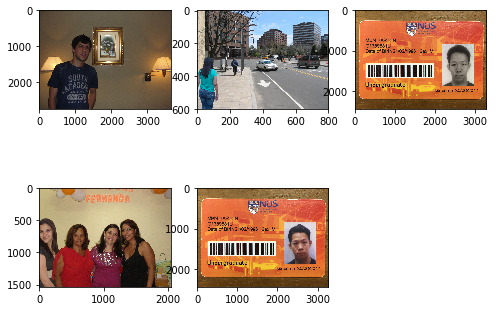

In [73]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(8, 6))

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(forged[i])


In [75]:
def count_255(mask):
    i=0
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]==255:
                i+=1
    return i

# binarize the masks 
import cv2
binaries = []
for grayscale in mask:
  blur = cv2.GaussianBlur(grayscale, (5,5), 0)
  ret, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  binaries.append(th)

In [76]:
stride= 64

im = forged[0]
mask_im = binaries[0]

images = [] 
images_mask = [] 

y_truth = [] 

for i in range(0, im.shape[0], stride):
    for j in range(0, im.shape[1], stride):
        
        if len(np.array(im[i:i+stride, j: j+stride, :]).flatten()) != 64 * 64 * 3:
            continue
        
        
        # 0 = pristine ; 1 = fake 
        if sum(sum(mask_im[i:i+stride, j: j+stride] == 255)) == 64*64:
            y_truth.append(0)
        else:
            c_255=count_255(mask_im[i:i+stride, j: j+stride]) # 255 = white
            c_0 = 64 * 64 - c_255 # 0 = black 
            if c_0 > threshold:
                y_truth.append(1)
                images_mask.append(mask_im[i:i+stride, j: j+stride])
            else:
                y_truth.append(0)
            
        images.append(np.array(im[i:i+stride, j: j+stride, :]))


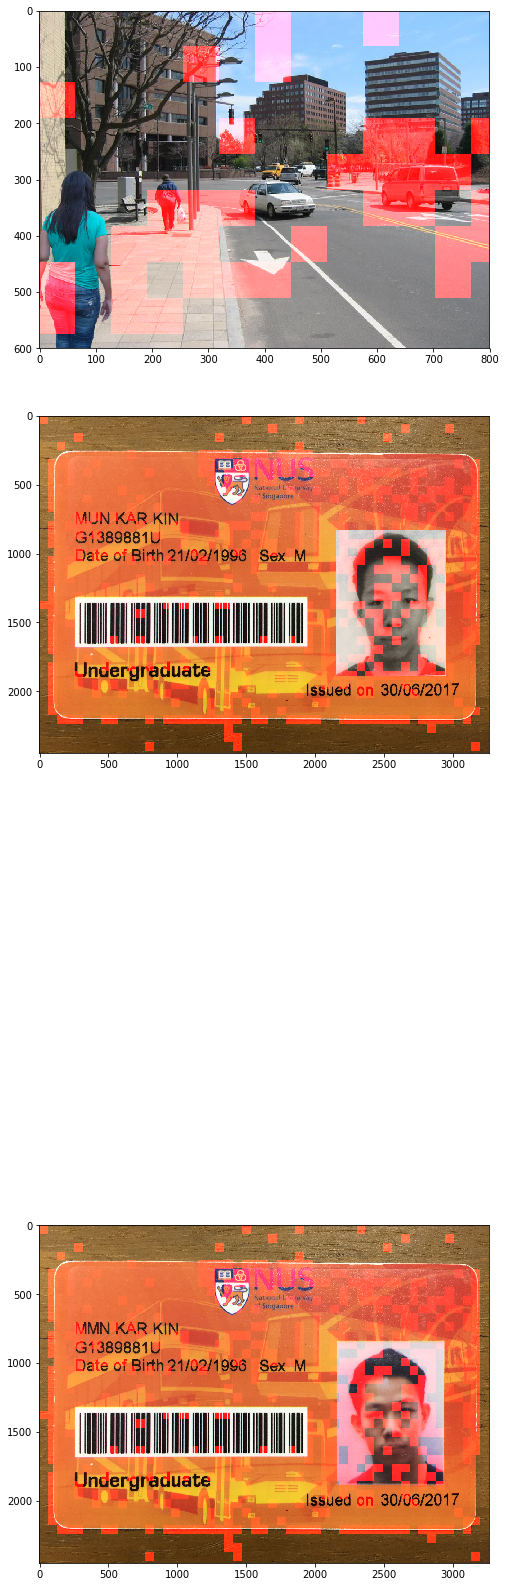

In [101]:
# do the same for the scenery image
stride= 64
fig = plt.figure(figsize=(12, 36))

for i in range(len(forged)):
    
    if i in [0, 3]:
        continue 
    
    ref = i  

    im = forged[ref]
    mask_im = binaries[ref]

    images = [] 
    images_mask = [] 

    y_truth = [] 

    for i in range(0, im.shape[0], stride):
        for j in range(0, im.shape[1], stride):

            if len(np.array(im[i:i+stride, j: j+stride, :]).flatten()) != 64 * 64 * 3:
                continue


            # 0 = pristine ; 1 = fake 
            if sum(sum(mask_im[i:i+stride, j: j+stride] == 255)) == 64*64:
                y_truth.append(0)
            else:
                c_255=count_255(mask_im[i:i+stride, j: j+stride]) # 255 = white
                c_0 = 64 * 64 - c_255 # 0 = black 
                if c_0 > threshold:
                    y_truth.append(1)
                    images_mask.append(mask_im[i:i+stride, j: j+stride])
                else:
                    y_truth.append(0)

            images.append(np.array(im[i:i+stride, j: j+stride, :]))
            
    y_pred = model.predict_classes(np.array(images))
    
    im_vis = forged[ref].copy()
    count = 0 

    for i in range(0, im_vis.shape[0], stride):
        for j in range(0, im_vis.shape[1], stride):

            try:

                if y_pred[count][0] == 1:
                    im_vis[i:i+stride, j: j+stride, 0] = 255

                count += 1 
            except:
                pass
            
    ax = fig.add_subplot(5, 1, ref+1)
    ax.imshow(im_vis, cmap = 'gray')


